In [1]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn
import torch_geometric.transforms
import torch_geometric.utils
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from node2vec import Node2Vec
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from IPython.display import Image
from copy import deepcopy

In [2]:
torch_geometric.seed_everything(0)

IO configs

In [3]:
data_dir = Path(".").absolute().parent / "data"
models_dir = data_dir / "models"
models_dir.mkdir(exist_ok=True)

In [4]:
retrain_baselines = True
retrain_gcn = True
retrain_fp = True

## Data loading and preprocessing
Load data

In [5]:
node2vec_embedding = pd.read_pickle(data_dir / "embeddings/node2vec_embedding.pkl")
spectral_embedding = pd.read_pickle(data_dir / "embeddings/spectral_embedding.pkl")
node_info = pd.read_pickle(data_dir / "preprocessed/node_info.pkl")
edge_info = pd.read_pickle(data_dir / "preprocessed/edge_info.pkl")


In [6]:
node2vec_embedding.head()

,node2vec_ACH_0,node2vec_ACH_1,node2vec_ACH_2,node2vec_ACH_3,node2vec_ACH_4,node2vec_ACH_5,node2vec_ACH_6,node2vec_ACH_7,node2vec_SER_0,node2vec_SER_1,...,node2vec_DA_6,node2vec_DA_7,node2vec_OCT_0,node2vec_OCT_1,node2vec_OCT_2,node2vec_OCT_3,node2vec_OCT_4,node2vec_OCT_5,node2vec_OCT_6,node2vec_OCT_7
720575940621280688,-2.191900,0.049500,-0.072872,2.529746,-0.076199,-0.797629,0.910458,2.138495,0.024376,0.049488,...,2.257592,-1.052635,-0.086376,-0.016342,-0.075253,0.132493,0.043961,-0.032677,0.089628,0.128388
720575940629174889,-1.859022,1.641020,0.985564,2.125586,-0.007060,1.693392,-0.502335,0.876726,0.076958,-1.087816,...,1.963795,-0.368879,0.061196,0.024918,0.113039,0.013703,0.092897,-0.082858,-0.096461,-0.012831
720575940637132389,-1.602327,0.615010,0.530065,1.076127,-0.032424,2.005130,-0.967994,0.755368,0.100470,-0.249987,...,1.295472,-1.272117,0.060951,0.014239,-0.058449,-0.046567,-0.092479,0.090280,0.040239,-0.106398
720575940654777505,-6.589922,-6.693934,2.004244,0.055977,-4.032084,3.622172,8.605543,3.299473,-0.115199,0.002871,...,0.115346,-0.042695,0.112006,0.021041,0.086480,0.051845,-0.034308,-0.000330,-0.061942,0.119736
720575940616159371,-6.747396,-7.012646,2.138878,0.055543,-4.097299,3.801588,8.909692,3.433254,-0.042529,0.076106,...,-0.012369,-0.027677,0.123636,0.086710,0.055061,0.047037,-0.039150,-0.109720,-0.061458,-0.098871


Merge node info (containing morphological features and target labels) with node features

In [7]:
node_info_cols = [
    "root_id", "super_class", "class", "hemilineage",
    "length_nm", "area_nm", "size_nm"
]
node_info_merged = pd.merge(
    node_info[node_info_cols].set_index("root_id"),
    node2vec_embedding,
    how="right",
    left_index=True,
    right_index=True,
)
node_info_merged = pd.merge(
    node_info_merged,
    spectral_embedding,
    how="left",
    left_index=True,
    right_index=True,
)
node_info_merged = node_info_merged.rename(
    columns={
        "length_nm": "morph_length", "area_nm": "morph_area", "size_nm": "morph_size"
    }
)

In [8]:
node_info_merged.head()

,super_class,class,hemilineage,morph_length,morph_area,morph_size,node2vec_ACH_0,node2vec_ACH_1,node2vec_ACH_2,node2vec_ACH_3,...,spectral_DA_6,spectral_DA_7,spectral_OCT_0,spectral_OCT_1,spectral_OCT_2,spectral_OCT_3,spectral_OCT_4,spectral_OCT_5,spectral_OCT_6,spectral_OCT_7
720575940621280688,central,MBIN,NaN,42474828,170716759168,11388240896000,-2.191900,0.049500,-0.072872,2.529746,...,-0.000459,-0.000101,-0.004504,0.000367,-0.000205,-0.000023,-0.000088,0.000124,-0.000062,0.000099
720575940629174889,central,MBIN,NaN,42979456,169932248320,11757734236160,-1.859022,1.641020,0.985564,2.125586,...,-0.000853,-0.000122,-0.004436,0.000358,-0.000198,-0.000022,-0.000085,0.000119,-0.000059,0.000095
720575940637132389,central,MBIN,NaN,20778086,112883269248,6248738539520,-1.602327,0.615010,0.530065,1.076127,...,-0.000359,0.000273,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092
720575940654777505,central,NaN,NaN,3049104,14418566016,1265078210560,-6.589922,-6.693934,2.004244,0.055977,...,0.000108,0.000091,-0.004404,0.000341,-0.000164,-0.000067,-0.000056,0.000115,-0.000060,0.000086
720575940616159371,central,NaN,VLPl2_medial,3678799,16298574976,1078699100160,-6.747396,-7.012646,2.138878,0.055543,...,0.000108,0.000091,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092


Preprocessing: remove minor classes, encode classes with integers, standardize feature columns.

In [9]:
class_size_thrs = {"super_class": 100, "class": 100, "hemilineage": 200}
id2name_lookups = {}
name2id_lookups = {}
for pred_target, thr in class_size_thrs.items():
    # Remove minor classes
    counts = node_info_merged[pred_target].value_counts()
    valid_classes = counts[counts >= thr].index
    mask = node_info_merged[pred_target].isin(valid_classes)
    node_info_merged.loc[~mask, pred_target] = np.nan

    # Encode classes with integers (-1 == other classes)
    id2name = dict(enumerate(valid_classes))
    name2id = {v: k for k, v in id2name.items()}
    node_info_merged[pred_target] = [
        name2id[x] if x in valid_classes else -1
        for x in node_info_merged[pred_target].values
    ]
    id2name_lookups[pred_target] = id2name
    name2id_lookups[pred_target] = name2id

# Standardize feature columns
cols_to_standardize = [
    col for col in node_info_merged.columns
    if col.split("_")[0] in ("node2vec", "spectral", "morph")
]
scaler = StandardScaler()
scaler.fit(node_info_merged[cols_to_standardize])
node_info_merged[cols_to_standardize] = scaler.transform(
    node_info_merged[cols_to_standardize]
)

In [10]:
node_info_merged.head()

,super_class,class,hemilineage,morph_length,morph_area,morph_size,node2vec_ACH_0,node2vec_ACH_1,node2vec_ACH_2,node2vec_ACH_3,...,spectral_DA_6,spectral_DA_7,spectral_OCT_0,spectral_OCT_1,spectral_OCT_2,spectral_OCT_3,spectral_OCT_4,spectral_OCT_5,spectral_OCT_6,spectral_OCT_7
720575940621280688,0,-1,-1,34.399891,38.680037,32.062323,-1.375980,0.070053,-0.098817,2.124283,...,-0.117059,-0.032241,-0.355508,0.039667,-0.030084,-0.002355,-0.014320,0.018590,-0.010154,0.015700
720575940629174889,0,-1,-1,34.819189,38.498702,33.124552,-0.928484,2.327172,1.174319,1.654374,...,-0.206240,-0.036830,-0.120393,0.037671,-0.028552,-0.002168,-0.013634,0.017523,-0.009600,0.014807
720575940637132389,0,-1,-1,16.371938,25.312181,17.287160,-0.583402,0.872068,0.626424,0.434185,...,-0.094306,0.052727,0.065077,0.036091,-0.027338,-0.002020,-0.013094,0.016680,-0.009164,0.014090
720575940654777505,0,-1,-1,1.640821,2.552669,2.960015,-7.288356,-9.493595,2.399634,-0.751927,...,0.011581,0.011346,-0.010467,0.033734,-0.020902,-0.012187,-0.007213,0.016590,-0.009796,0.012696
720575940616159371,0,-1,13,2.164038,2.987221,2.424208,-7.500051,-9.945597,2.561578,-0.752432,...,0.011581,0.011346,0.065077,0.036091,-0.027338,-0.002020,-0.013094,0.016680,-0.009164,0.014090


Percentages of neurons with valid labels in each classification task:

In [11]:
print(
    (node_info_merged["super_class"] != -1).sum() / len(node_info_merged),
    (node_info_merged["class"] != -1).sum() / len(node_info_merged),
    (node_info_merged["hemilineage"] != -1).sum() / len(node_info_merged),
)

0.9986577181208054 0.4021009629413481 0.25262134033654315


Split train/val/test sets

In [12]:
trainval_df, test_df = train_test_split(
    node_info_merged, test_size=0.2, random_state=0
)
train_df, val_df = train_test_split(
    trainval_df, test_size=0.25, random_state=0
)
split_dfs = {
    "train": train_df, "val": val_df, "test": test_df
}

## Non-GNN baselines
Logistic regression and MLP

In [13]:
_columns_all = list(node_info_merged.columns)
feature_columns = {
    "node2vec": [
        col for col in _columns_all
        if col.split("_")[0] in ("morph", "node2vec")
    ],
    "spectral": [
        col for col in _columns_all
        if col.split("_")[0] in ("morph", "spectral")
    ],
    "both": [
        col for col in _columns_all
        if col.split("_")[0] in ("morph", "node2vec", "spectral")
    ]
}

In [14]:
results_all = []
for pred_target in ["super_class", "class", "hemilineage"]:
    for features_group in ["node2vec", "spectral", "both"]:
        # Fetch x, y
        x_cols = feature_columns[features_group]
        train_x = train_df[x_cols]
        train_y = train_df[pred_target]
        train_x = train_x[train_y != -1]
        train_y = train_y[train_y != -1]
        val_x = val_df[x_cols]
        val_y = val_df[pred_target]
        val_x = val_x[val_y != -1]
        val_y = val_y[val_y != -1]
        test_x = test_df[x_cols]
        test_y = test_df[pred_target]
        test_x = test_x[test_y != -1]
        test_y = test_y[test_y != -1]
        assert train_x.shape[1] == val_x.shape[1] == len(x_cols)

        # Train and evaluate models
        models = {
            "lr": LogisticRegression(max_iter=1000, random_state=0),
            "mlp": MLPClassifier(
                hidden_layer_sizes=[16, 16], max_iter=1000, random_state=0
            ),
        }
        for model_name, model in models.items():
            model_path = (
                models_dir / f"{model_name}_{pred_target}_{features_group}.pkl"
            )

            # Train model or load from parameters file
            if retrain_baselines:
                model.fit(train_x, train_y)
                with open(model_path, "wb") as f:
                    pickle.dump(model, f)
            else:
                with open(model_path, "rb") as f:
                    model = pickle.load(f)

            # Evaluate model on testing set
            test_pred = model.predict(test_x)
            acc = accuracy_score(test_y, test_pred)
            f1 = f1_score(test_y, test_pred, average='macro')
            results_all.append([model_name, pred_target, features_group, acc, f1])
            print(
                f"{model_name} - Predicting {pred_target} from {features_group} "
                f"features: acc={acc:.4f}, f1={f1:.4f}"
            )

lr - Predicting super_class from node2vec features: acc=0.8241, f1=0.5144
mlp - Predicting super_class from node2vec features: acc=0.8945, f1=0.5951
lr - Predicting super_class from spectral features: acc=0.7621, f1=0.3440
mlp - Predicting super_class from spectral features: acc=0.8551, f1=0.4917
lr - Predicting super_class from both features: acc=0.8429, f1=0.5565
mlp - Predicting super_class from both features: acc=0.8990, f1=0.5855
lr - Predicting class from node2vec features: acc=0.8896, f1=0.8138
mlp - Predicting class from node2vec features: acc=0.9067, f1=0.8225
lr - Predicting class from spectral features: acc=0.7260, f1=0.5284
mlp - Predicting class from spectral features: acc=0.8932, f1=0.7951
lr - Predicting class from both features: acc=0.9024, f1=0.8370
mlp - Predicting class from both features: acc=0.9145, f1=0.8377
lr - Predicting hemilineage from node2vec features: acc=0.4733, f1=0.5322
mlp - Predicting hemilineage from node2vec features: acc=0.4798, f1=0.5492
lr - Pred

## GNN models

### Build PyG graph object

Build NetworkX graph

In [15]:
edge_info = edge_info[
    edge_info["pre_root_id"].isin(node_info_merged.index)
    & edge_info["post_root_id"].isin(node_info_merged.index)
]
edge_info.head()

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940619238582,720575940634854554,AVLP_R,35,ACH
1,720575940634034839,720575940660217473,AL_R,38,SER
2,720575940612615570,720575940604789676,EB,26,GABA
3,720575940614901215,720575940626983952,PRW,70,GABA
4,720575940627312104,720575940625498512,SMP_R,28,GLUT


In [16]:
nx_graph = nx.from_pandas_edgelist(
    edge_info, source="pre_root_id", target="post_root_id", create_using=nx.DiGraph
)
node_info_merged_w_mask = node_info_merged.copy()
node_info_merged_w_mask["train_mask"] = (
    node_info_merged_w_mask.index.isin(train_df.index)
)
node_info_merged_w_mask["val_mask"] = (
    node_info_merged_w_mask.index.isin(val_df.index)
)
node_info_merged_w_mask["test_mask"] = (
    node_info_merged_w_mask.index.isin(test_df.index)
)
nx.set_node_attributes(nx_graph, node_info_merged_w_mask.to_dict(orient="index")) 

Define node features to be grouped and masks to select them

In [17]:
num_dims_per_nt = 8
nt_types = ["ACH", "GABA", "GLUT", "SER", "DA", "OCT"]

all_features = (
    [f"node2vec_{nt}_{i}" for nt in nt_types for i in range(num_dims_per_nt)]
    + [f"spectral_{nt}_{i}" for nt in nt_types for i in range(num_dims_per_nt)]
    + ["morph_length", "morph_area", "morph_size"]
)
node2vec_mask = np.array(
    [col.split("_")[0] in ("node2vec", "morph") for col in all_features]
)
spectral_mask = np.array(
    [col.split("_")[0] in ("spectral", "morph") for col in all_features]
)
both_mask = np.ones(len(all_features), dtype="bool")

Build PyG graph

In [18]:
pg_graph = torch_geometric.utils.from_networkx(
    nx_graph, group_node_attrs=all_features
)

In [19]:
pg_graph

Data(edge_index=[2, 1090673], super_class=[49339], class=[49339], hemilineage=[49339], train_mask=[49339], val_mask=[49339], test_mask=[49339], x=[49339, 99])

### Train GCN

In [20]:
class MyGCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, features_mask):
        super(MyGCN, self).__init__()
        self.features_mask = features_mask
        self.conv1 = gnn.GCNConv(in_dim, hidden_dim)
        self.conv2 = gnn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = gnn.GCNConv(hidden_dim, out_dim)
    
    def forward(self, data):
        x = data.x[:, features_mask]
        x = self.conv1(x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        x = F.relu(x)
        x = self.conv3(x, data.edge_index)
        return x

In [21]:
def train(
    model, graph, optimizer, criterion, num_epochs, target_col, device, verbose=False
):
    training_hist = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_acc": [],
        "val_f1": [],
    }
    best_model_state = None
    best_epoch = -1
    best_val_f1 = -1
    
    # We exclude rows without a valid target label. The exact rows to exclude
    # depends on the target column, and therefore is decided here
    train_mask = graph.train_mask & (graph[target_col] != -1)
    val_mask = graph.val_mask & (graph[target_col] != -1)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[train_mask], graph[target_col][train_mask])
        loss.backward()
        optimizer.step()

        # Logging
        if epoch % 10 == 0:
            train_acc, train_f1 = get_scores(model, graph, train_mask, target_col)
            val_acc, val_f1 = get_scores(model, graph, val_mask, target_col)
            training_hist["epoch"].append(epoch)
            training_hist["train_loss"].append(loss.item())
            training_hist["train_acc"].append(train_acc)
            training_hist["train_f1"].append(train_f1)
            training_hist["val_acc"].append(val_acc)
            training_hist["val_f1"].append(val_f1)
            if best_model_state is None or best_val_f1 < val_f1:
                best_model_state = deepcopy(model.state_dict())
                best_epoch = epoch
                best_val_f1 = val_f1
            if epoch % 100 == 0 and verbose:
                print(
                    f"Epoch {epoch} | Train loss {loss.item():.4f} | "
                    f"Train acc {train_acc:.4f} | Train F1 {train_f1:.4f} | "
                    f"Val acc {val_acc:.4f} | Val F1 {val_f1:.4f}"
                )

    # Revert to model with best validation F1
    last_acc, last_f1 = get_scores(model, graph, val_mask, target_col)
    # best_id = np.argmax([val_f1 for params, val_f1 in model_states])
    # best_id = 1
    # model.load_state_dict(model_states[best_id][0])
    model.load_state_dict(best_model_state)
    best_acc, best_f1 = get_scores(model, graph, val_mask, target_col)
    print(
        f"Using model at epoch {best_epoch}: "
        f"last epoch acc={last_acc:.4f}, f1={last_f1:.4f}; "
        f"best epoch acc={best_acc:.4f}, f1={best_f1:.4f}"
    )

    return pd.DataFrame.from_dict(training_hist)

def get_scores(model, graph, mask, target_col):
    model.eval()
    pred = model(graph)[mask].argmax(dim=1).cpu().detach().numpy()
    label = graph[target_col][mask].cpu().detach().numpy()
    acc = accuracy_score(label, pred)
    f1 = f1_score(label, pred, average='macro')
    return acc, f1

In [22]:
def visualize_training_history(training_hist):
    fig, axs = plt.subplots(1, 2, figsize=(5, 2), tight_layout=True)
    axs[0].plot(training_hist["epoch"], training_hist["train_loss"])
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Training loss")
    axs[1].plot(training_hist["epoch"], training_hist["train_f1"], label="Training")
    axs[1].plot(training_hist["epoch"], training_hist["val_f1"], label="Validation")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("F1 score")
    axs[1].set_ylim([0, 1.02])
    axs[1].legend(loc="lower right")
    sns.despine(fig=fig)

Epoch 0 | Train loss 2.7651 | Train acc 0.1178 | Train F1 0.0394 | Val acc 0.1125 | Val F1 0.0374
Epoch 100 | Train loss 0.5007 | Train acc 0.8515 | Train F1 0.6708 | Val acc 0.8396 | Val F1 0.6607
Epoch 200 | Train loss 0.2961 | Train acc 0.9074 | Train F1 0.8057 | Val acc 0.8840 | Val F1 0.7772
Epoch 300 | Train loss 0.2316 | Train acc 0.9259 | Train F1 0.8468 | Val acc 0.8933 | Val F1 0.7970
Epoch 400 | Train loss 0.1995 | Train acc 0.9351 | Train F1 0.8651 | Val acc 0.8936 | Val F1 0.8050
Epoch 500 | Train loss 0.1798 | Train acc 0.9407 | Train F1 0.8764 | Val acc 0.9012 | Val F1 0.8268
Epoch 600 | Train loss 0.1643 | Train acc 0.9463 | Train F1 0.8871 | Val acc 0.9023 | Val F1 0.8288
Epoch 700 | Train loss 0.1535 | Train acc 0.9482 | Train F1 0.8850 | Val acc 0.8999 | Val F1 0.8212
Epoch 800 | Train loss 0.1432 | Train acc 0.9524 | Train F1 0.8986 | Val acc 0.9018 | Val F1 0.8312
Epoch 900 | Train loss 0.1376 | Train acc 0.9536 | Train F1 0.8966 | Val acc 0.8999 | Val F1 0.8238
Ep

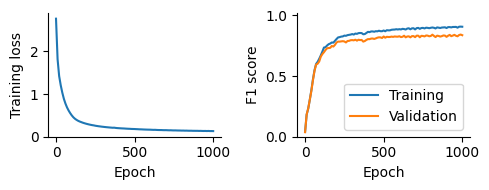

In [23]:
pred_target = "class"
features_group, features_mask = "node2vec", node2vec_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()

gcn_model = MyGCN(
    in_dim=features_mask.sum(),
    hidden_dim=16,
    out_dim=len(id2name_lookups[pred_target]),
    features_mask=features_mask
).to(device)

optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

training_hist = train(
    gcn_model,
    pg_graph.to(device),
    optimizer,
    criterion,
    1000 + 1,
    pred_target,
    device,
    verbose=True
)

test_mask = pg_graph.test_mask & (pg_graph[pred_target] != -1)
test_acc, test_f1 = get_scores(gcn_model, pg_graph, test_mask, pred_target)

visualize_training_history(training_hist)

===== Training model to predict super_class from node2vec features =====
Using model at epoch 5660: last epoch acc=0.8909, f1=0.5786; best epoch acc=0.8901, f1=0.5906
GCN - Predicting super_class from node2vec features: acc=0.8866, f1=0.5479


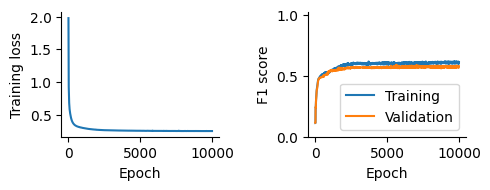

===== Training model to predict super_class from spectral features =====
Using model at epoch 9640: last epoch acc=0.8968, f1=0.6114; best epoch acc=0.8963, f1=0.6220
GCN - Predicting super_class from spectral features: acc=0.8902, f1=0.5828


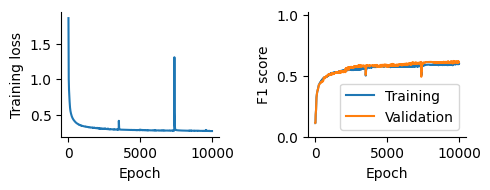

===== Training model to predict super_class from both features =====
Using model at epoch 9770: last epoch acc=0.9048, f1=0.6456; best epoch acc=0.9027, f1=0.6516
GCN - Predicting super_class from both features: acc=0.8946, f1=0.6169


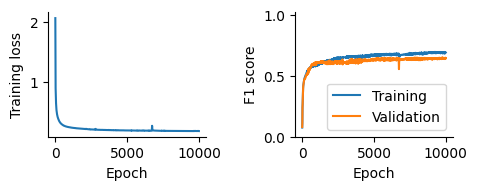

===== Training model to predict class from node2vec features =====
Using model at epoch 1280: last epoch acc=0.8975, f1=0.8278; best epoch acc=0.9092, f1=0.8454
GCN - Predicting class from node2vec features: acc=0.9010, f1=0.8290


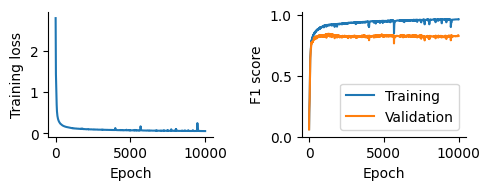

===== Training model to predict class from spectral features =====
Using model at epoch 5990: last epoch acc=0.9251, f1=0.8654; best epoch acc=0.9288, f1=0.8784
GCN - Predicting class from spectral features: acc=0.9216, f1=0.8682


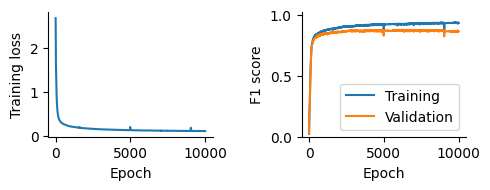

===== Training model to predict class from both features =====
Using model at epoch 5200: last epoch acc=0.9028, f1=0.8280; best epoch acc=0.9076, f1=0.8468
GCN - Predicting class from both features: acc=0.9021, f1=0.8403


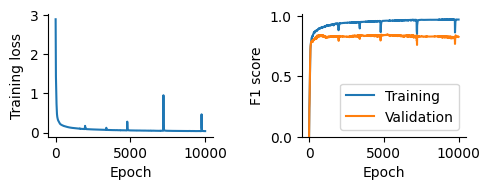

===== Training model to predict hemilineage from node2vec features =====
Using model at epoch 9080: last epoch acc=0.5366, f1=0.5840; best epoch acc=0.5335, f1=0.5858
GCN - Predicting hemilineage from node2vec features: acc=0.5256, f1=0.5678


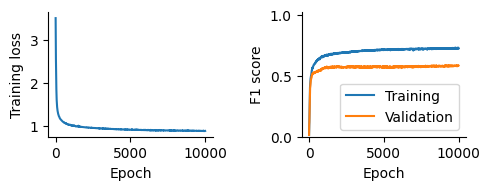

===== Training model to predict hemilineage from spectral features =====
Using model at epoch 9690: last epoch acc=0.5165, f1=0.5776; best epoch acc=0.5257, f1=0.5802
GCN - Predicting hemilineage from spectral features: acc=0.5156, f1=0.5657


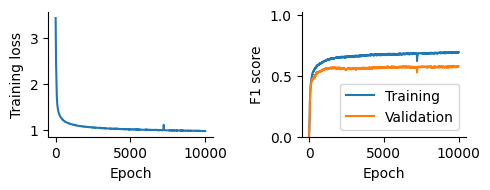

===== Training model to predict hemilineage from both features =====
Using model at epoch 2080: last epoch acc=0.5436, f1=0.5784; best epoch acc=0.5478, f1=0.6064
GCN - Predicting hemilineage from both features: acc=0.5379, f1=0.5764


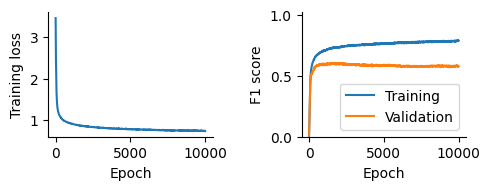

In [24]:
feature_mask_lookup = {
    "node2vec": node2vec_mask, "spectral": spectral_mask, "both": both_mask
}

for pred_target in ["super_class", "class", "hemilineage"]:
    for features_group, features_mask in feature_mask_lookup.items():
        print(
            f"===== Training model to predict {pred_target} "
            f"from {features_group} features ====="
        )
        gcn_model = MyGCN(
            in_dim=features_mask.sum(),
            hidden_dim=16,
            out_dim=len(id2name_lookups[pred_target]),
            features_mask=features_mask
        ).to(device)
        model_path = models_dir / f"gcn_{pred_target}_{features_group}.pth"

        # Train model if needed, otherwise load from pth file
        if retrain_gcn:
            optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)
            criterion = nn.CrossEntropyLoss()
            training_hist = train(
                gcn_model,
                pg_graph.to(device),
                optimizer,
                criterion,
                10000 + 1,
                pred_target,
                device,
                verbose=False
            )
            torch.save(gcn_model.state_dict(), model_path)
            visualize_training_history(training_hist)
        else:
            gcn_model.load_state_dict(torch.load(model_path))

        test_mask = pg_graph.test_mask & (pg_graph[pred_target] != -1)
        acc, f1 = get_scores(gcn_model, pg_graph, test_mask, pred_target)
        results_all.append(["gcn", pred_target, features_group, acc, f1])
        print(
            f"GCN - Predicting {pred_target} from {features_group} "
            f"features: acc={acc:.4f}, f1={f1:.4f}"
        )
        
        plt.show()

### Train GAT

In [25]:
class MyGAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, features_mask):
        super(MyGAT, self).__init__()
        self.features_mask = features_mask
        self.att1 = gnn.GATv2Conv(in_dim, hidden_dim)
        self.att2 = gnn.GATv2Conv(hidden_dim, hidden_dim)
        self.att3 = gnn.GATv2Conv(hidden_dim, out_dim)
        #self.relu = nn.LeakyReLU()
    
    def forward(self, data):
        x = data.x[:, features_mask]
        x = self.att1(x, data.edge_index)
        x = F.relu(x)
        x = self.att2(x, data.edge_index)
        x = F.relu(x)
        x = self.att3(x, data.edge_index)
        return x

Epoch 0 | Train loss 2.5703 | Train acc 0.2212 | Train F1 0.0738 | Val acc 0.2105 | Val F1 0.0723
Epoch 100 | Train loss 0.3238 | Train acc 0.8916 | Train F1 0.7280 | Val acc 0.8758 | Val F1 0.7069
Epoch 200 | Train loss 0.2403 | Train acc 0.8976 | Train F1 0.8283 | Val acc 0.8652 | Val F1 0.7869
Epoch 300 | Train loss 0.1515 | Train acc 0.9521 | Train F1 0.9019 | Val acc 0.9055 | Val F1 0.8255
Epoch 400 | Train loss 0.1164 | Train acc 0.9634 | Train F1 0.9300 | Val acc 0.9044 | Val F1 0.8273
Epoch 500 | Train loss 0.1243 | Train acc 0.9601 | Train F1 0.9180 | Val acc 0.9023 | Val F1 0.8137
Epoch 600 | Train loss 0.0966 | Train acc 0.9698 | Train F1 0.9399 | Val acc 0.9018 | Val F1 0.8159
Epoch 700 | Train loss 0.0847 | Train acc 0.9718 | Train F1 0.9446 | Val acc 0.9002 | Val F1 0.8056
Epoch 800 | Train loss 0.0773 | Train acc 0.9762 | Train F1 0.9549 | Val acc 0.8983 | Val F1 0.8004
Epoch 900 | Train loss 0.0704 | Train acc 0.9789 | Train F1 0.9602 | Val acc 0.9026 | Val F1 0.8149
Ep

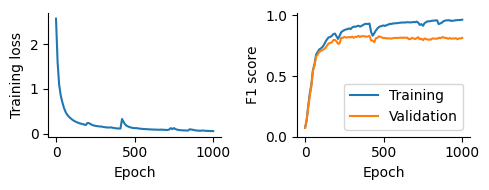

In [26]:
# let's train the model
pred_target = "class"
features_group, features_mask = "node2vec", node2vec_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()

gat_model = MyGAT(
    in_dim=int(features_mask.sum()),
    hidden_dim=16,
    out_dim=len(id2name_lookups[pred_target]),
    features_mask=features_mask
).to(device)

optimizer = optim.Adam(gat_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

training_hist = train(
    gat_model,
    pg_graph.to(device),
    optimizer,
    criterion,
    1000 + 1,
    pred_target,
    device,
    verbose=True
)

visualize_training_history(training_hist)

### Fast Parapred (Deac et al., 2018)

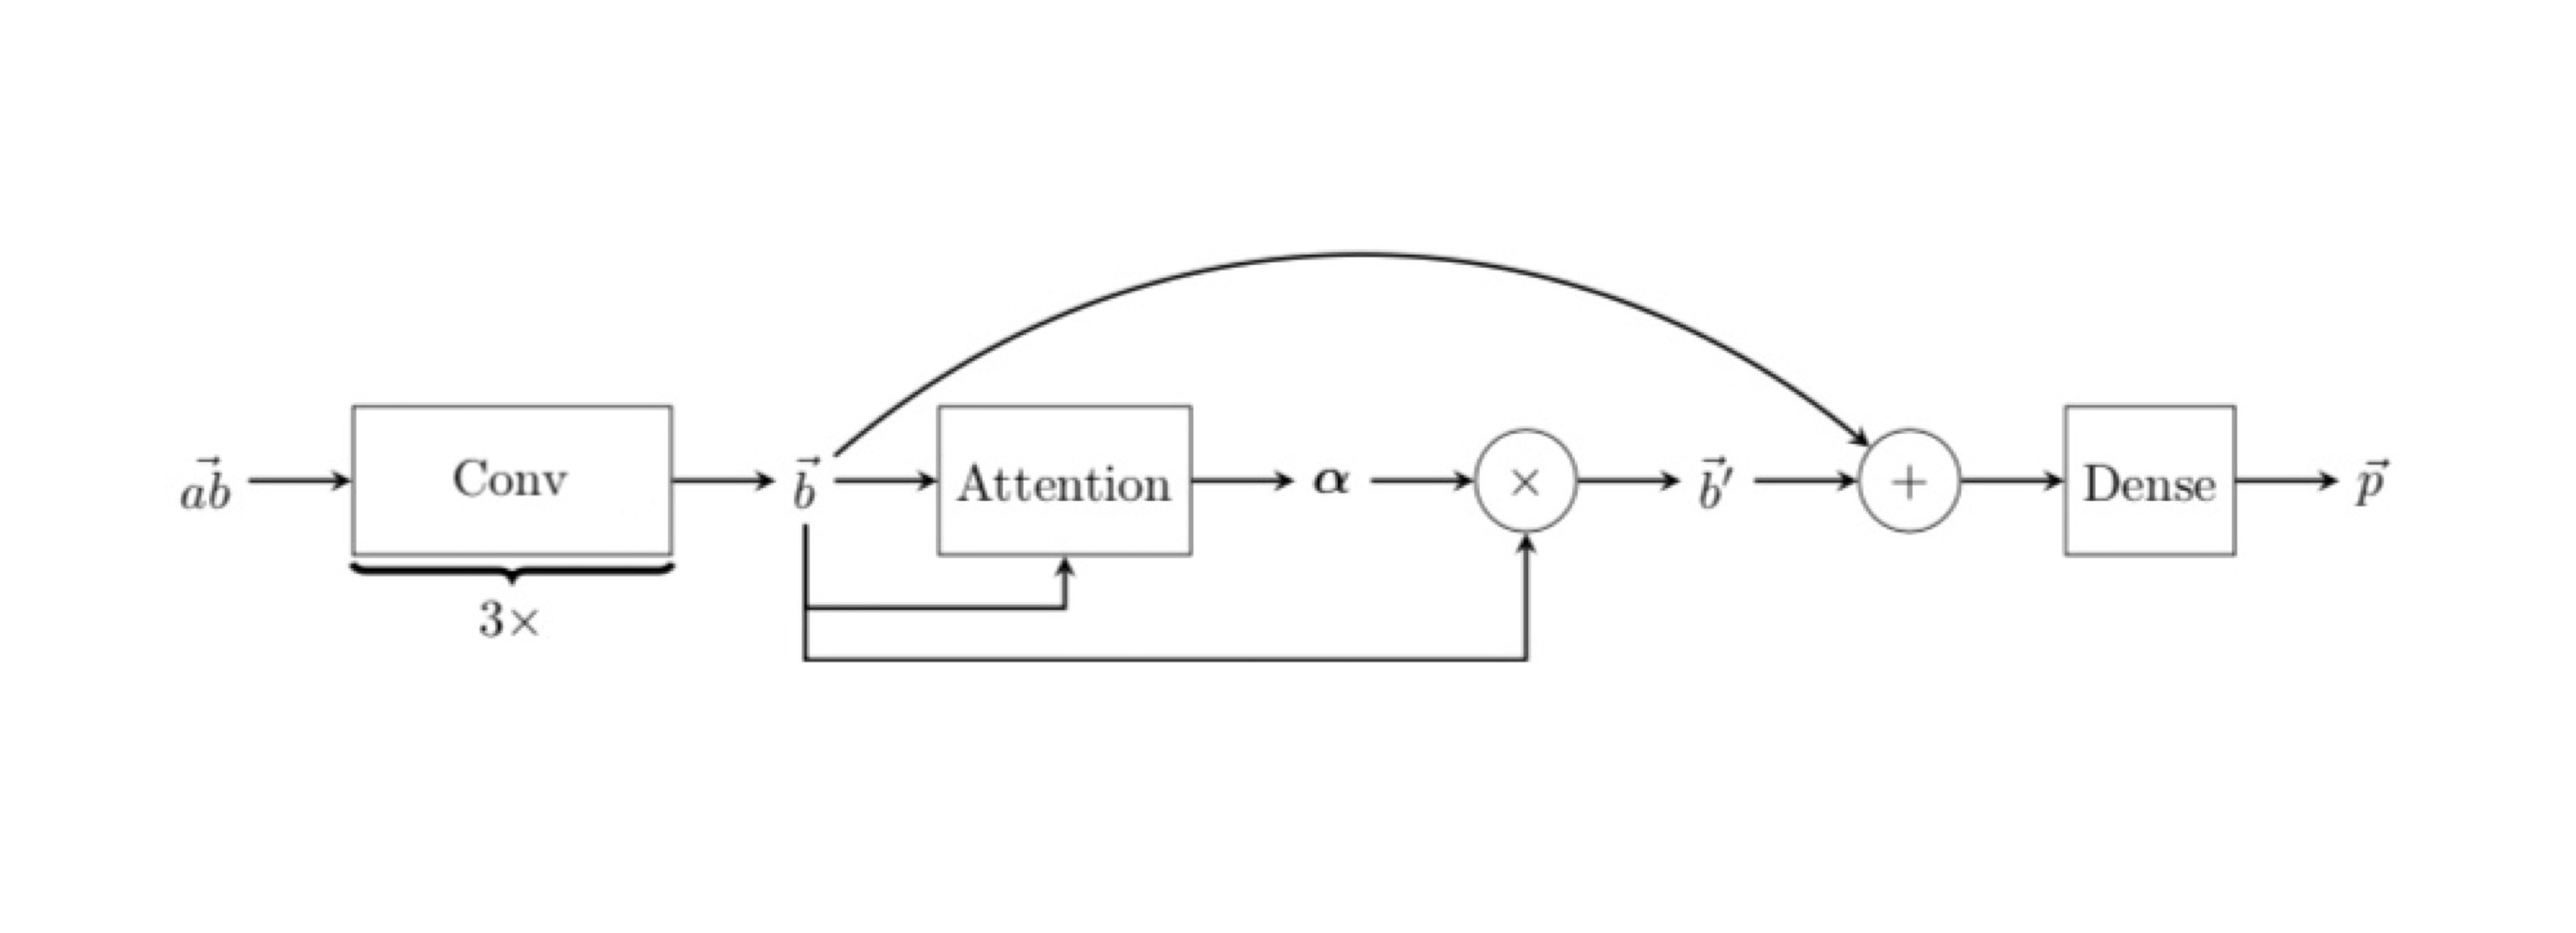

In [27]:
Image(filename = "../figs/FastParapred.JPG", width = 1000, height = 250)

In [28]:
class FastParapred(nn.Module):
    def __init__(self, in_dim, out_dim, features_mask):
        super(FastParapred, self).__init__()
        self.features_mask = features_mask
        self.features_mask = features_mask
        self.conv1 = gnn.GCNConv(in_dim, 32)
        # self.conv2 = gnn.GCNConv(64, 128)
        # self.conv3 = gnn.GCNConv(128, 256)
        self.att = gnn.GATv2Conv(32, 32)

        # self.att = gnn.GATv2Conv(256, 256)

        # self.classifier = gnn.Linear(256, out_dim)
        self.classifier = gnn.Linear(32, out_dim)

    def forward(self, data):
        x = data.x[:, features_mask]
        x = data.x[:, features_mask]
        conv_out = self.conv1(x, data.edge_index)
        x = F.relu(conv_out)
        # x = self.conv2(x, data.edge_index)
        # x = F.relu(x)
        # x = self.conv3(x, data.edge_index)
        # x = F.relu(x)
        atten_out = self.att(x, data.edge_index)
        x = self.classifier(conv_out + atten_out)
        return x


Epoch 0 | Train loss 2.5088 | Train acc 0.3226 | Train F1 0.0939 | Val acc 0.3272 | Val F1 0.0946
Epoch 100 | Train loss 0.2392 | Train acc 0.9148 | Train F1 0.8425 | Val acc 0.9063 | Val F1 0.8253
Epoch 200 | Train loss 0.1424 | Train acc 0.9518 | Train F1 0.9099 | Val acc 0.9203 | Val F1 0.8548
Epoch 300 | Train loss 0.1016 | Train acc 0.9666 | Train F1 0.9363 | Val acc 0.9275 | Val F1 0.8673
Epoch 400 | Train loss 0.0719 | Train acc 0.9765 | Train F1 0.9556 | Val acc 0.9264 | Val F1 0.8689
Epoch 500 | Train loss 0.0539 | Train acc 0.9842 | Train F1 0.9720 | Val acc 0.9272 | Val F1 0.8709
Epoch 600 | Train loss 0.0362 | Train acc 0.9908 | Train F1 0.9835 | Val acc 0.9232 | Val F1 0.8669
Epoch 700 | Train loss 0.0237 | Train acc 0.9953 | Train F1 0.9903 | Val acc 0.9192 | Val F1 0.8584
Epoch 800 | Train loss 0.0153 | Train acc 0.9973 | Train F1 0.9950 | Val acc 0.9206 | Val F1 0.8625
Epoch 900 | Train loss 0.5663 | Train acc 0.8731 | Train F1 0.8034 | Val acc 0.8494 | Val F1 0.7549
Ep

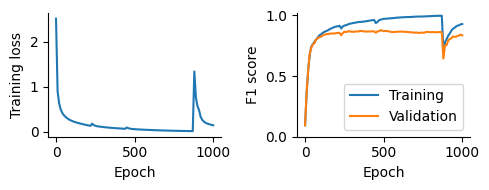

In [29]:
pred_target = "class"
features_group, features_mask = "node2vec", node2vec_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()

fp_model = FastParapred(
    in_dim=int(features_mask.sum()),
    out_dim=len(id2name_lookups[pred_target]),
    features_mask=features_mask
).to(device)

optimizer = optim.Adam(fp_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

training_hist = train(
    fp_model,
    pg_graph.to(device),
    optimizer,
    criterion,
    1000 + 1,
    pred_target,
    device,
    verbose=True
)

visualize_training_history(training_hist)

===== Training model to predict super_class from node2vec features =====
Using model at epoch 1140: last epoch acc=0.8778, f1=0.5905; best epoch acc=0.9011, f1=0.6880
FP - Predicting super_class from node2vec features: acc=0.8987, f1=0.6591


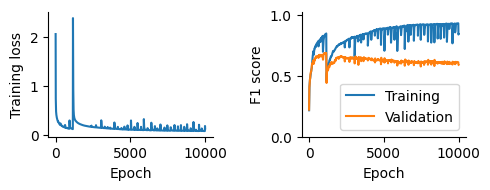

===== Training model to predict super_class from spectral features =====
Using model at epoch 3320: last epoch acc=0.8884, f1=0.6470; best epoch acc=0.8950, f1=0.6638
FP - Predicting super_class from spectral features: acc=0.8879, f1=0.6223


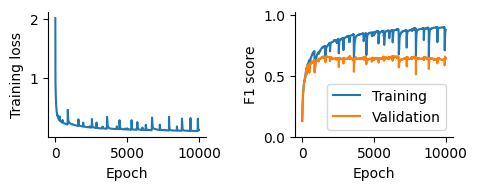

===== Training model to predict super_class from both features =====
Using model at epoch 1590: last epoch acc=0.8826, f1=0.6341; best epoch acc=0.9040, f1=0.6874
FP - Predicting super_class from both features: acc=0.8963, f1=0.6457


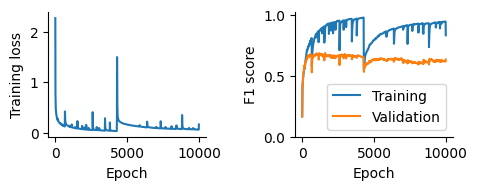

===== Training model to predict class from node2vec features =====
Using model at epoch 610: last epoch acc=0.9063, f1=0.8396; best epoch acc=0.9235, f1=0.8635
FP - Predicting class from node2vec features: acc=0.9183, f1=0.8609


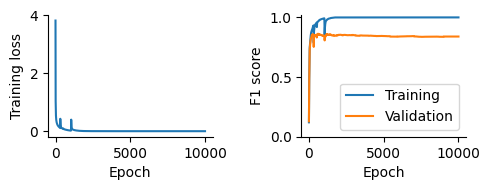

===== Training model to predict class from spectral features =====
Using model at epoch 7390: last epoch acc=0.9145, f1=0.8514; best epoch acc=0.9206, f1=0.8721
FP - Predicting class from spectral features: acc=0.9056, f1=0.8418


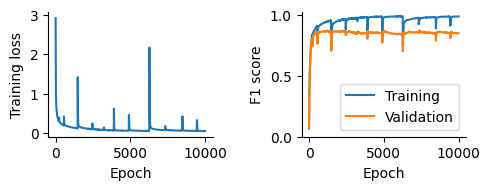

===== Training model to predict class from both features =====
Using model at epoch 500: last epoch acc=0.9126, f1=0.8412; best epoch acc=0.9261, f1=0.8826
FP - Predicting class from both features: acc=0.9183, f1=0.8663


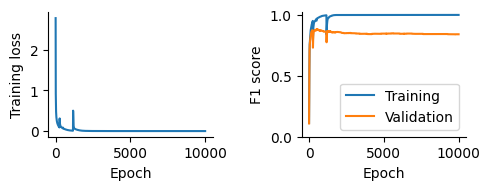

===== Training model to predict hemilineage from node2vec features =====
Using model at epoch 1220: last epoch acc=0.5354, f1=0.5872; best epoch acc=0.5861, f1=0.6500
FP - Predicting hemilineage from node2vec features: acc=0.5705, f1=0.6266


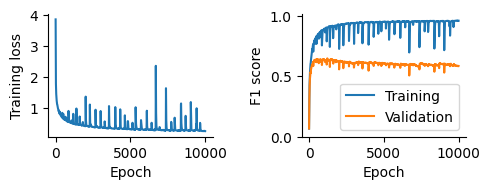

===== Training model to predict hemilineage from spectral features =====
Using model at epoch 1300: last epoch acc=0.4890, f1=0.5185; best epoch acc=0.5242, f1=0.5682
FP - Predicting hemilineage from spectral features: acc=0.5271, f1=0.5607


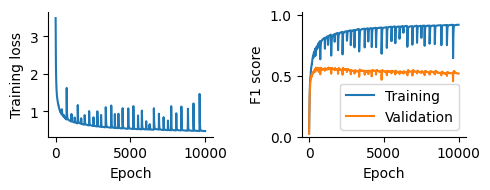

===== Training model to predict hemilineage from both features =====
Using model at epoch 490: last epoch acc=0.5443, f1=0.5999; best epoch acc=0.5919, f1=0.6542
FP - Predicting hemilineage from both features: acc=0.5952, f1=0.6608


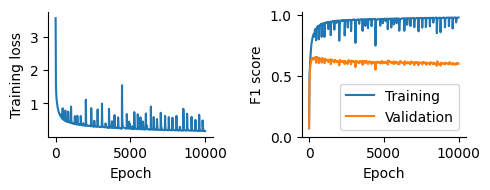

In [30]:
for pred_target in ["super_class", "class", "hemilineage"]:
    for features_group, features_mask in feature_mask_lookup.items():
        print(
            f"===== Training model to predict {pred_target} "
            f"from {features_group} features ====="
        )
        fp_model = FastParapred(
            in_dim=int(features_mask.sum()),
            out_dim=len(id2name_lookups[pred_target]),
            features_mask=features_mask
        ).to(device)
        model_path = models_dir / f"fp_{pred_target}_{features_group}.pth"

        # Train model if needed, otherwise load from pth file
        if retrain_fp:
            optimizer = optim.Adam(fp_model.parameters(), lr=0.01)
            criterion = nn.CrossEntropyLoss()
            training_hist = train(
                fp_model,
                pg_graph.to(device),
                optimizer,
                criterion,
                10000 + 1,
                pred_target,
                device,
                verbose=False
            )
            torch.save(fp_model.state_dict(), model_path)
            visualize_training_history(training_hist)
        else:
            fp_model.load_state_dict(torch.load(model_path))

        test_mask = pg_graph.test_mask & (pg_graph[pred_target] != -1)
        acc, f1 = get_scores(fp_model, pg_graph, test_mask, pred_target)
        results_all.append(["fp", pred_target, features_group, acc, f1])
        print(
            f"FP - Predicting {pred_target} from {features_group} "
            f"features: acc={acc:.4f}, f1={f1:.4f}"
        )
        
        plt.show()

In [31]:
results_all_df = pd.DataFrame(
    results_all, columns=["model", "pred_target", "feature_group", "accuracy", "f1"]
)
results_all_df

,model,pred_target,feature_group,accuracy,f1
0,lr,super_class,node2vec,0.824068,0.514365
1,mlp,super_class,node2vec,0.894460,0.595118
2,lr,super_class,spectral,0.762146,0.344048
3,mlp,super_class,spectral,0.855126,0.491710
4,lr,super_class,both,0.842859,0.556493
5,mlp,super_class,both,0.899036,0.585515
6,lr,class,node2vec,0.889587,0.813777
7,mlp,class,node2vec,0.906741,0.822530
8,lr,class,spectral,0.726021,0.528421
9,mlp,class,spectral,0.893211,0.795145


In [32]:
results_all_df.to_csv(models_dir / "classification_stats.csv", index=False)

Number of classes per classification task:

In [33]:
for task, id2name in id2name_lookups.items():
    print(f"{task}: {len(id2name)} tasks")

super_class: 7 tasks
class: 15 tasks
hemilineage: 30 tasks
